In [6]:
import os
import sys
sys.path.append("..")
import numpy as np
from py_helpers.general_helpers import *
import warnings

# Define the paths to the results
labs = False
if labs:
    results_path_bayes = "/media/hsa22/Expansion/WBM/results"
    results_path_grid = "/media/hsa22/Expansion/WBM_grid/results"
else:
    results_path_bayes = "D:\\WBM\\results"
    results_path_grid = "D:\\WBM_grid\\results"

# Filter warnings
warnings.filterwarnings("ignore")

## **Load the Data**

In [7]:
# Define the neural models
neural_models_grid = ["kuramoto"]
neural_models_bayes = ["wilson", "kuramoto"]

# Define the modes
modes = ["model", "traditional", "tracer"]

# Define the symmetric and asymmetric modes
symmetric_modes = ["asymmetric"]

In [8]:
# Grab all the txt and csv files for the correlation
txt_files = {"bayes": glob_files(results_path_bayes, "txt"), "grid": glob_files(results_path_grid, "txt")}
csv_files = {"bayes": glob_files(results_path_bayes, "csv"), "grid": glob_files(results_path_grid, "csv")}

print("Number of txt files: {} bayes, {} grid".format(len(txt_files["bayes"]), len(txt_files["grid"])))
print("Number of csv files: {} bayes, {} grid".format(len(csv_files["bayes"]), len(csv_files["grid"])))

# Assert that the number of txt and csv files are the same
assert len(txt_files["bayes"]) == len(csv_files["bayes"]), "Number of txt and csv files are not the same for bayes!"

# Separate text files into correlation and order
corr_txt_files = {"bayes": [file for file in txt_files["bayes"] if "corr" in file], "grid": [file for file in txt_files["grid"] if "corr" in file]}
order_txt_files = {"bayes": [file for file in txt_files["bayes"] if "order" in file], "grid": [file for file in txt_files["grid"] if "order" in file]}

# Separate csv files into sim_FC and bold
sim_FC_csv_files = {"bayes": [file for file in csv_files["bayes"] if "sim_FC" in file], "grid": [file for file in csv_files["grid"] if "sim_FC" in file]}
bold_csv_files = {"bayes": [file for file in csv_files["bayes"] if "bold" in file], "grid": [file for file in csv_files["grid"] if "bold" in file]}

print("Number of correlation text files: {} bayes, {} grid".format(len(corr_txt_files["bayes"]), len(corr_txt_files["grid"])))
print("Number of order text files: {} bayes, {} grid".format(len(order_txt_files["bayes"]), len(order_txt_files["grid"])))
print("Number of sim_FC csv files: {} bayes, {} grid".format(len(sim_FC_csv_files["bayes"]), len(sim_FC_csv_files["grid"])))
print("Number of bold csv files: {} bayes, {} grid".format(len(bold_csv_files["bayes"]), len(bold_csv_files["grid"])))

# Assert that the number of correlation, order, sim_FC and bold files are the same
assert len(corr_txt_files["bayes"]) == len(order_txt_files["bayes"]) == len(sim_FC_csv_files["bayes"]) == len(bold_csv_files["bayes"]), "Number of correlation, order, sim_FC and bold files are not the same for bayes!"
assert len(corr_txt_files["grid"]) == len(order_txt_files["grid"]) == len(sim_FC_csv_files["grid"]), "Number of correlation, order, and sim_FC files are not the same for grid!"

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np

def organize_files(corr_txt_files, order_txt_files, sim_FC_csv_files, bold_csv_files, name="model"):
    """Organizes provided files into a structured dictionary."""

    # Initialize the dictionary to store the organized files
    organized_files = {}

    # Debug print
    # print(f"Organizing files for: {name}")

    # Loop through the correlation text files
    for file in corr_txt_files:
        # Filter by the provided name (e.g., "model")
        if name in file:
            # Identify if it's symmetric or not from the directory structure
            symmetric = file.split(os.sep)[-3]

            # Construct paths to the corresponding files
            base_dir = os.path.dirname(file)
            corresponding_sim_FC_path = os.path.join(base_dir, "sim_FC.csv")
            corresponding_bold_path = os.path.join(base_dir, "bold_filtered.csv") if os.path.join(base_dir, "bold_filtered.csv") in bold_csv_files else None
            corresponding_order_path = os.path.join(base_dir, "order_data.txt")

            # Check if the sim_FC and order paths exist
            if (corresponding_sim_FC_path in sim_FC_csv_files and 
                corresponding_order_path in order_txt_files):

                # Extract coupling and delay from the base directory
                coupling_delay_parts = base_dir.split(os.sep)[-1].split(",")  # Assuming format "Coupling x.xxxx, Delay x.xxxx"
                coupling = coupling_delay_parts[0].split(" ")[1]
                delay = coupling_delay_parts[1].split(" ")[1]

                data_dict = {
                    "corr_txt_path": file,
                    "order_txt_path": corresponding_order_path,
                    "sim_FC_csv_path": corresponding_sim_FC_path,
                    "bold_csv_path": corresponding_bold_path,
                    "correlation": np.loadtxt(file),
                    "order": np.loadtxt(corresponding_order_path),
                    "coupling": coupling,
                    "delay": delay
                }

                # Store the data dictionary under the symmetric/asymmetric key
                organized_files.setdefault(symmetric, []).append(data_dict)

            # Debug print for missing files
            else:
                print(f"Skipped {file} because of missing corresponding files!")
                if corresponding_sim_FC_path not in sim_FC_csv_files:
                    print(f"Missing sim_FC file: {corresponding_sim_FC_path}")
                if corresponding_order_path not in order_txt_files:
                    print(f"Missing order file: {corresponding_order_path}")

    return organized_files


In [ ]:
# Create dictionary that will store the files
neural_model_dict = {}

# Define the file dictionaries for bayes and grid 
file_dicts = {
    "bayes": {
        "corr_txt_files": corr_txt_files["bayes"],
        "order_txt_files": order_txt_files["bayes"],
        "sim_FC_csv_files": sim_FC_csv_files["bayes"],
        "bold_csv_files": bold_csv_files["bayes"]
    },
    "grid": {
        "corr_txt_files": corr_txt_files["grid"],
        "order_txt_files": order_txt_files["grid"],
        "sim_FC_csv_files": sim_FC_csv_files["grid"],
    }
}

# Mapping between data types and their corresponding neural models
data_neural_map = {
    "bayes": neural_models_bayes,
    "grid": neural_models_grid
}

# Iterate over the defined dictionaries
for data_type, file_dict in file_dicts.items():
    for neural_model in data_neural_map[data_type]:

        # print("-"*50)
        # print("Current neural model: {}".format(neural_model))

        # Get the neural model files individually
        neural_model_corr_txt_files = [file for file in file_dict["corr_txt_files"] if neural_model in file]
        neural_model_order_txt_files = [file for file in file_dict["order_txt_files"] if neural_model in file]
        neural_model_sim_FC_csv_files = [file for file in file_dict["sim_FC_csv_files"] if neural_model in file]
        neural_model_bold_csv_files = file_dict.get("bold_csv_files", [])  # Using get() in case the key is missing.
        if neural_model_bold_csv_files:
            neural_model_bold_csv_files = [file for file in neural_model_bold_csv_files if neural_model in file]

        for mode in modes:

            # print("Current mode: {}".format(mode))

            # Define dictionary for model, traditional, and tracer files
            neural_files = organize_files(neural_model_corr_txt_files, 
                                          neural_model_order_txt_files, 
                                          neural_model_sim_FC_csv_files, 
                                          neural_model_bold_csv_files, 
                                          name=mode)
                    
            # Append the neural_files to the neural_model_dict
            if (neural_model, data_type) in neural_model_dict:
                neural_model_dict[(neural_model, data_type)][mode] = neural_files
            else:
                neural_model_dict[(neural_model, data_type)] = {mode: neural_files}

print("-"*50)
print("COMPLETED ORGANIZING FILES")

# Print the max correlation for each neural model
for (neural_model, data_type) in neural_model_dict:
    print("-" * 50)
    print("\n")
    print("Neural model: {}, Data type: {}".format(neural_model, data_type))
    print("\n")
    
    for mode in neural_model_dict[(neural_model, data_type)]:
        for symmetric in neural_model_dict[(neural_model, data_type)][mode]:

            # Find the maximum correlation and its corresponding file
            max_correlation_file = max(neural_model_dict[(neural_model, data_type)][mode][symmetric], 
                                       key=lambda x: np.max(x["correlation"]))
            max_corr = np.max(max_correlation_file["correlation"])

            # Retrieve coupling and delay from the max_correlation_file
            coupling = max_correlation_file["coupling"]
            delay = max_correlation_file["delay"]

            print("Max {}, {} correlation: {}".format(mode, symmetric, max_corr))
            print("Coupling: {}, Delay: {} ms".format(coupling, delay))
            print("\n")


--------------------------------------------------
COMPLETED ORGANIZING FILES
--------------------------------------------------


Neural model: wilson, Data type: bayes


Max model, asymmetric correlation: 0.07656223
Coupling: 0.5834, Delay: Delay0.3579 ms


Max traditional, asymmetric correlation: 0.03386032
Coupling: 0.1078, Delay: Delay3.0028 ms


Max tracer, asymmetric correlation: 0.08600686
Coupling: 1.0000, Delay: Delay44.8569 ms


--------------------------------------------------


Neural model: kuramoto, Data type: bayes


Max model, asymmetric correlation: 0.32306988
Coupling: 1.0000, Delay: Delay6.4226 ms


Max traditional, asymmetric correlation: 0.09057822
Coupling: 1.0000, Delay: Delay4.6495 ms


Max traditional, symmetric correlation: 0.04192981
Coupling: 0.0075, Delay: Delay29.7787 ms


Max tracer, asymmetric correlation: 0.3502793
Coupling: 0.1197, Delay: Delay4.9722 ms


--------------------------------------------------


Neural model: kuramoto, Data type: grid


M

## **Organize Data into Pandas Dataframe**

In [ ]:
import pandas as pd
import re

# Function to organize data into pandas dataframe
def extract_data_and_create_df(entries):
    """Utility function to extract data and create a dataframe."""
    df_rows = []
    for entry in entries:
        # Extract the coupling and delay values using regex
        match = re.search(r"Coupling (\d+\.\d+), Delay(\d+\.\d+)", entry["corr_txt_path"])
        
        if match:
            coupling, delay = float(match.group(1)), float(match.group(2))
            df_rows.append((coupling, delay, entry["correlation"], entry["order"][0], entry["order"][1]))

    return pd.DataFrame(df_rows, columns=["Coupling", "Delay", "Correlation", "Order Mean", "Order Std"])

def create_dataframes_for_models(neural_model_dict):
    
    # Initialize empty dictionary for the output
    output_dict = {}

    for (neural_model, data_type) in neural_model_dict.keys():

        # Initialize empty dictionary for the data type if not exists
        if neural_model not in output_dict:
            output_dict[neural_model] = {}
        if data_type not in output_dict[neural_model]:
            output_dict[neural_model][data_type] = {}

        for mode in modes:

            # Initialize empty dictionary for the mode
            output_dict[neural_model][data_type][mode] = {}

            for symm in symmetric_modes:
                entries = neural_model_dict[(neural_model, data_type)][mode][symm]
                output_dict[neural_model][data_type][mode][symm] = extract_data_and_create_df(entries)

    return output_dict


In [ ]:
# Create dataframes for the models
dataframes = create_dataframes_for_models(neural_model_dict)
print(dataframes["kuramoto"]["bayes"]["tracer"]["asymmetric"].head())

   Coupling    Delay Correlation  Order Mean  Order Std
0    0.5881  44.8857  0.00450341    0.058496   0.029316
1    0.6628   9.4888  0.22780522    0.702168   0.238972
2    0.4637  34.0699  0.02954461    0.071703   0.045366
3    0.7946   9.0152  0.23105065    0.726543   0.228603
4    0.3632   9.1293  0.24037317    0.721722   0.228182


## **Plot the Data**

#### Kuramoto Grid and Bayes

In [206]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

%matplotlib widget

def gradient_stem(ax, x, y, z, bottom, color_start, color_end):
    """
    Create a stem plot with gradient color effect.
    :param ax: Axis to plot on
    :param x, y, z: Data for stems
    :param bottom: Bottom of stems
    :param colors: List of color for gradient
    """
    segments = len(z)
    for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
        z_points = np.linspace(bottom, zi, segments)
        colors = [((zi - v) / (zi - bottom) * np.array(color_start) + (v - bottom) / (zi - bottom) * np.array(color_end)) for v in z_points]
        for j in range(1, segments):
            ax.plot([xi, xi], [yi, yi], [z_points[j-1], z_points[j]], color=colors[j])
            
        # Here we add the circle top at the end of each stem
        ax.scatter(xi, yi, zi, c=[tuple(color_end)], s=20)  # You can adjust `s` for size

def plot_bayesOpt_results(df, title, xlabel, ylabel, zlabel):

    # Get the bayes and grid dataframes
    df_bayes = df["bayes"]
    df_grid = df["grid"]

    print("Shape of bayes dataframe: {}".format(df_bayes.shape))
    print("Shape of grid dataframe: {}".format(df_grid.shape))

    # Generate a custom color palette
    color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.1, light=0.9)
    beige_palette = sns.light_palette(color_palette[4], n_colors=10)
    
    # Extract specific colors
    pinkish = color_palette[5]
    purpleish = color_palette[7]
    beige_color = beige_palette[1]

    # Create a custom colormap using these colors
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom", 
        [beige_color, pinkish, purpleish]
    )

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)
    
    ax1 = ax[0]

    # get the x, y, and z values
    coupling_grid = df_grid['Coupling']
    delay_grid = df_grid['Delay']
    corr_grid = [val.item() for val in df_grid['Correlation'].values]

    # Create a grid for interpolation
    grid_x, grid_y = np.mgrid[coupling_grid.min():coupling_grid.max():200j, delay_grid.min():delay_grid.max():200j]

    # Interpolate the Correlation values over the grid
    grid_z = griddata((coupling_grid, delay_grid), corr_grid, (grid_x, grid_y), method='cubic')

    # Apply Gaussian smoothing
    sigma = 5.8  # This determines the width of the Gaussian kernel, adjust as necessary
    smoothed_grid_z = gaussian_filter(grid_z, sigma)

    # Now use the smoothed data for the contour plot
    num_grid_levels = 10
    c1 = ax1.contourf(grid_x, grid_y, smoothed_grid_z, levels=num_grid_levels, cmap=custom_cmap)

    # Contour lines with labels for ax1
    cs1 = ax1.contour(grid_x, grid_y, smoothed_grid_z, levels=num_grid_levels, colors='black')
    ax1.clabel(cs1, inline=True, fontsize=10, fmt='%1.2f')

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_title("Correlation Contour (Coupling vs. Delay)", fontsize=15)
    
    ################################ BAYES ################################

    # get the x, y, and z values
    coupling_bayes = df_bayes['Coupling']
    delay_bayes = df_bayes['Delay']
    corr_bayes = [val.item() for val in df_bayes['Correlation'].values]

    # Calculate KDE for ax2
    values = np.vstack([df_bayes['Coupling'], df_bayes['Delay']])
    kernel = gaussian_kde(values)

    x, y = np.mgrid[df_bayes['Coupling'].min():df_bayes['Coupling'].max():100j, df_bayes['Delay'].min():df_bayes['Delay'].max():100j]
    positions = np.vstack([x.ravel(), y.ravel()])
    z = np.reshape(kernel(positions).T, x.shape)
    
    ax2 = ax[1]
    # Filled contour
    c = ax2.contourf(x, y, z, levels=12, cmap=custom_cmap)

    # Contour lines with labels
    cs = ax2.contour(x, y, z, levels=12, colors='black')
    ax2.clabel(cs, inline=True, fontsize=10, fmt='%1.2f')
    
    fig.colorbar(c, ax=ax2, shrink=0.5, aspect=5)

    # Set labels for ax
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)

    # Add a title
    ax2.set_title("Density Estimation of BO's (Coupling, Delay) Choices", fontsize=15)

    # Set the title
    fig.suptitle("{title}".format(title=title), fontsize=20)

    plt.show()

Shape of bayes dataframe: (302, 5)
Shape of grid dataframe: (3779, 5)


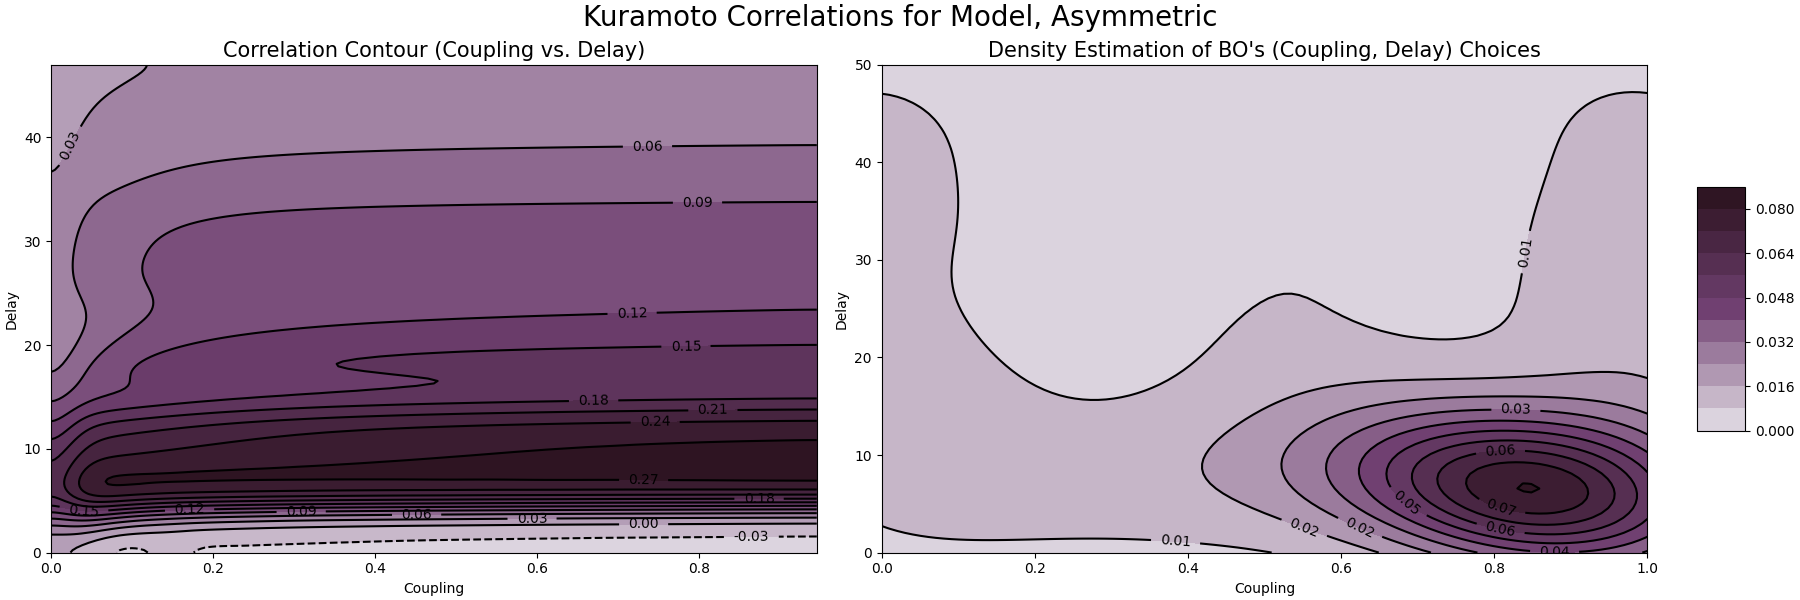

Shape of bayes dataframe: (303, 5)
Shape of grid dataframe: (3072, 5)


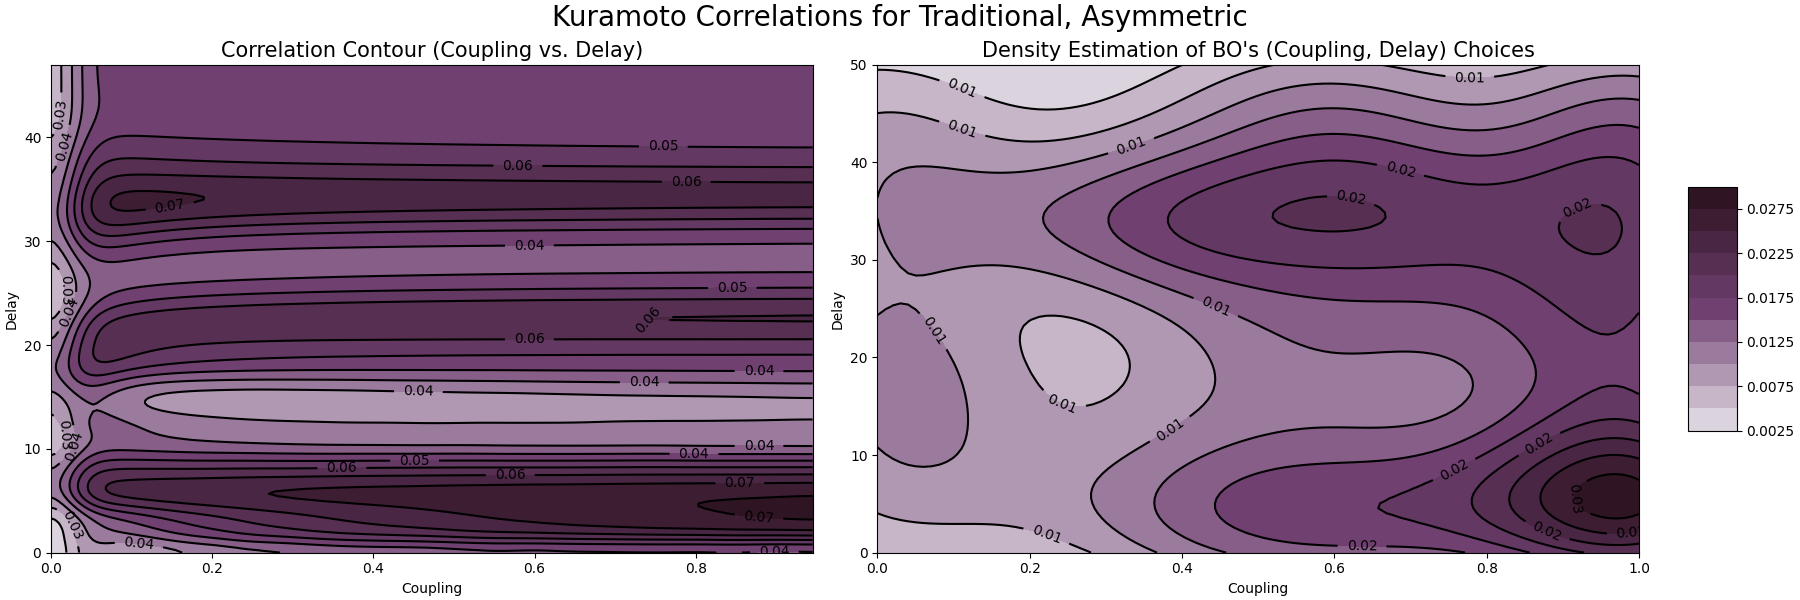

Shape of bayes dataframe: (302, 5)
Shape of grid dataframe: (3072, 5)


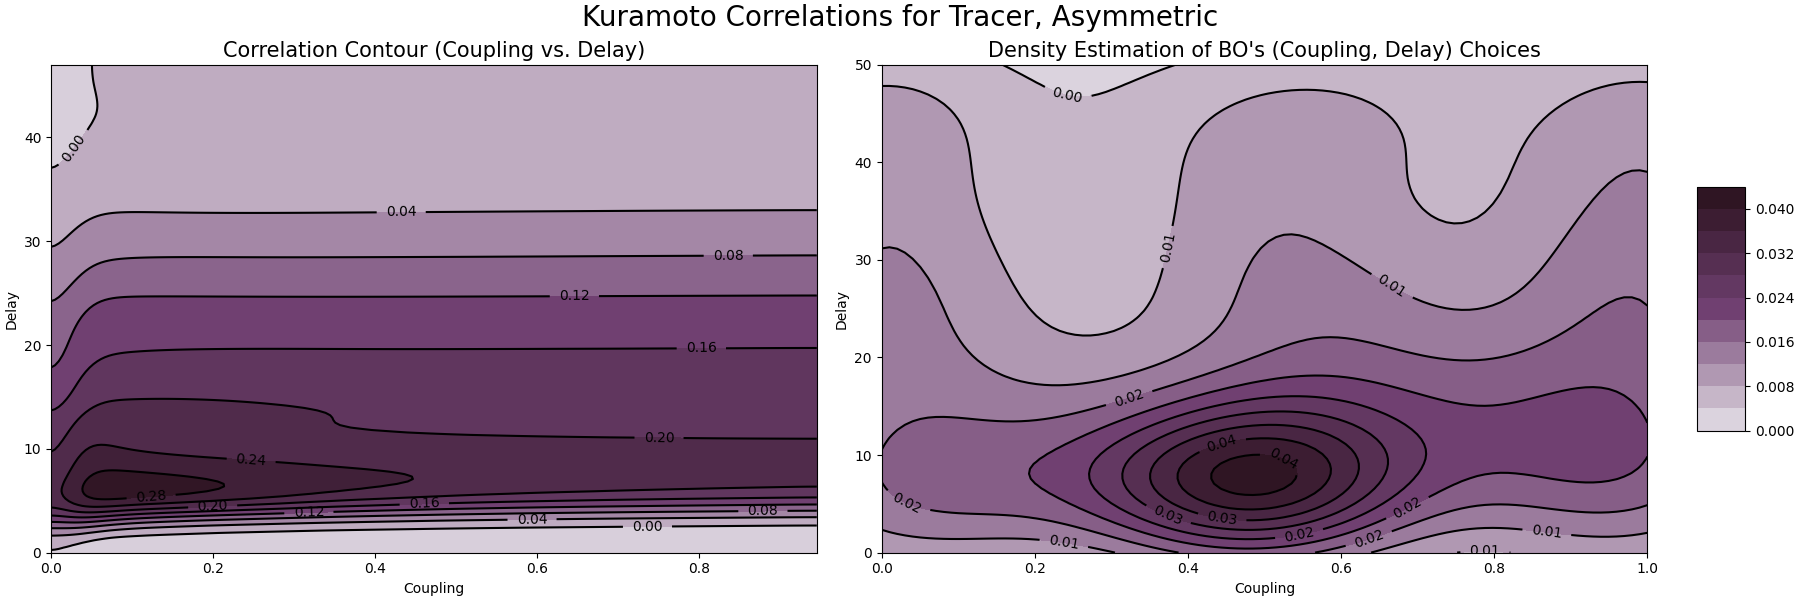

In [207]:
%matplotlib widget

# For each mode, plot the results
for mode in modes:

    # For each symmetry, plot the results
    for symm in symmetric_modes:

        # Extract the dataframe
        df_bayes = dataframes["kuramoto"]["bayes"][mode][symm]
        df_grid = dataframes["kuramoto"]["grid"][mode][symm]

        # Combine the two into a dictionary and pass that in
        df = {"bayes": df_bayes, "grid": df_grid}
        
        plot_bayesOpt_results(df, 
                                title="{neural_model} Correlations for {mode}, {symm}".format(neural_model=neural_model.capitalize(), 
                                                                                                            mode=mode.capitalize(), 
                                                                                                            symm=symm.capitalize()), 
                                xlabel="Coupling", 
                                ylabel="Delay", 
                                zlabel="Correlation")


#### Wilson Bayes

In [226]:
def plot_KDEs_by_key(df, title, xlabel, ylabel):

    # Generate a custom color palette
    color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.1, light=0.9)
    beige_palette = sns.light_palette(color_palette[4], n_colors=10)
    
    # Extract specific colors
    pinkish = color_palette[5]
    purpleish = color_palette[7]
    beige_color = beige_palette[1]

    # Create a custom colormap using these colors
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom", 
        [beige_color, pinkish, purpleish]
    )
    
    # Number of subplots based on keys in dataframe
    num_subplots = len(df.keys())

    # Visualization
    fig, axes = plt.subplots(1, num_subplots, figsize=(7 * num_subplots, 6), constrained_layout=True)

    # For single subplot case (only 1 key in dataframe), make axes a list
    if num_subplots == 1:
        axes = [axes]

    for key, ax in zip(df.keys(), axes):

        coupling = df[key]["asymmetric"]['Coupling']
        delay = df[key]["asymmetric"]['Delay']

        # Calculate KDE for the specific key
        values = np.vstack([coupling, delay])
        kernel = gaussian_kde(values)

        x, y = np.mgrid[coupling.min():coupling.max():100j, delay.min():delay.max():100j]
        positions = np.vstack([x.ravel(), y.ravel()])
        z = np.reshape(kernel(positions).T, x.shape)

        # Filled contour
        c = ax.contourf(x, y, z, levels=12, cmap=custom_cmap)

        # Contour lines with labels
        cs = ax.contour(x, y, z, levels=12, colors='black')
        ax.clabel(cs, inline=True, fontsize=10, fmt='%1.2f')

        # Adding a colorbar
        fig.colorbar(c, ax=ax, shrink=0.5, aspect=5)

        # Set labels for ax
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        # Add a title based on the key
        ax.set_title("Density Estimation of (Coupling, Delay) for {key}".format(key=key.capitalize()), fontsize=15)

    # Set the main title
    fig.suptitle(title, fontsize=20)

    plt.show()

dict_keys(['model', 'traditional', 'tracer'])


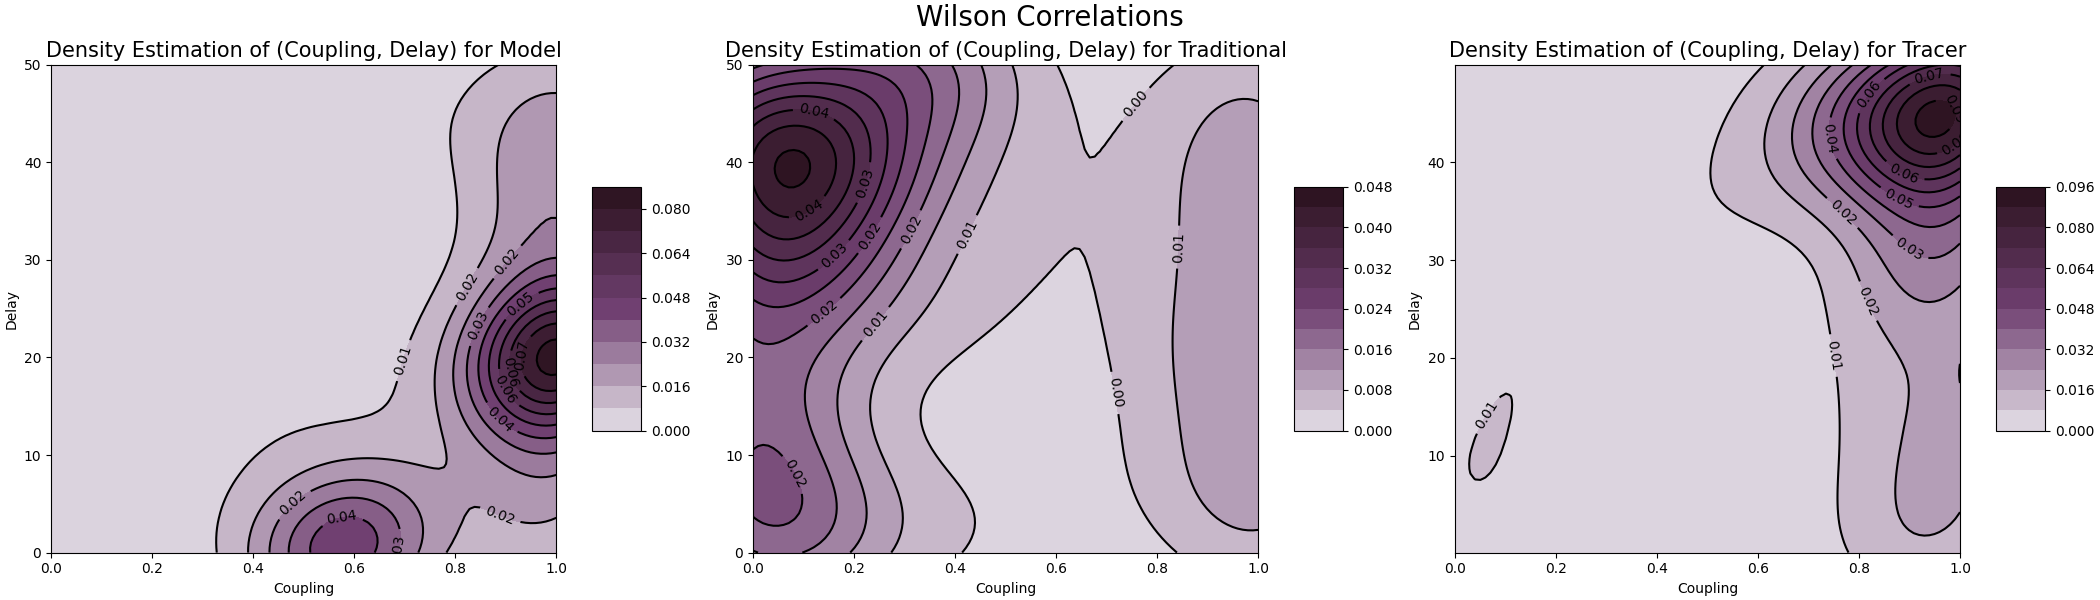

In [227]:
%matplotlib widget

# Extract the dataframe
df = dataframes["wilson"]["bayes"]

print(df.keys())

plot_KDEs_by_key(df, 
                title="Wilson Correlations".format(mode=mode.capitalize(), symm=symm.capitalize()), 
                xlabel="Coupling", 
                ylabel="Delay")


## **Plotting BOLD signal**

#### Getting the MBM Labels

In [ ]:
import os
import sys
sys.path.append("..")
import numpy as np
from py_helpers.general_helpers import *
import warnings


labs = True
if labs:
    # Define the path to the tractograms to evaluate
    results_path = "/media/hsa22/Expansion/deeplearning_test/test/test/brain_A6Vb-R01_0104-TT72/regression_points_directions/batch_0"
    bold_path = "/media/hsa22/Expansion/MBM_fmri/sub-NIHm32/ses-01/fmri_slices/sub-NIHm32_ses-01_task-rest_run-LR-2/processed_BOLD"
else:
    results_path = "D:\\deeplearning_test\\test\\test\\brain_A6Vb-R01_0104-TT72\\regression_points_directions\\batch_0"
    bold_path = "D:\\MBM_fmri\\sub-NIHm32\\ses-01\\fmri_slices\\sub-NIHm32_ses-01_task-rest_run-LR-2\\processed_BOLD"

# Get the atlas label paths
MBM_labels_path = os.path.join(results_path, "MBM_cortex_labels.txt")


In [2]:
# Dictionary to store the results
MBM_label_data = {}
    
# Load the data from MBM
with open(MBM_labels_path, 'r') as file:
    for line in file:
        # Split each line into columns
        columns = line.strip().split() 
        # Extract the first column (assuming it's a number) and the last column (label)
        number = float(columns[-1])
        label = columns[0]

        # Save to dictionary
        MBM_label_data[number] = label

# Print the number of labels
print("Number of labels in MBM: {}".format(len(MBM_label_data)))

Number of labels in MBM: 54


#### Get the BOLD Signals

In [4]:
# Grab all npy files and filter for ones with bold
npy_files = glob_files(bold_path, "npy")
bold_files = [file for file in npy_files if "BOLD" in file.split(os.sep)[-1].split("_")[1]]

# Filter for MBM files
MBM_bold_files = [file for file in bold_files if "MBM" in file.split(os.sep)[-1].split("_")[0]]

print("Number of bold files: {}".format(len(MBM_bold_files)))

NameError: name 'glob_files' is not defined

In [ ]:
# Define the BOLD plotting function
def plot_BOLD(bold, title, xlabel, ylabel, zlabel):

    pass

In [ ]:
# For each neural model, plot the results
for neural_model in neural_models:

    # For each mode, plot the results
    for mode in modes:

        # For each symmetry, plot the results
        for symm in symmetric_modes:

            # Extract the dataframe
            df = dataframes[neural_model][mode][symm]

            # Plot the results
            plot_BOLD(df, 
                    title="Neural Model: {neural_model}, Mode: {mode}, Symmetry: {symm}".format(neural_model=neural_model, mode=mode, symm=symm), 
                    xlabel="Coupling", 
                    ylabel="Delay", 
                    zlabel="Correlation")